In [48]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, MultiHeadAttention, Dense, Input, Dropout, LayerNormalization
from google.colab import files,drive

# Reduced dimension of our model
n_px = 32
n_embd = 128 
n_head = 4
n_layer = 8

# Small iGPT dimensions
# n_px = 32
# n_embd = 512 
# n_head = 8 
# n_layer = 24 

n_vocab = 513 # length of clusters + 1
maxlen = n_px*n_px
num_batch = 16
num_epochs = 32

color_clusters_dir = "/content/clusters"
bs = 8 

In [49]:
def create_look_ahead_mask(size):
  """Returns an upper triangular matrix filled with ones"""
  mask = tf.linalg.band_part(tf.ones((size, size)), 0, -1)
 
  return mask 

def attention(Q,K,V,mask):
  """Returns the masked attention weights"""
  matmul_qk = tf.matmul(q,k,transpose_b = True)
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
  
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
  output = tf.matmul(attention_weights, v)

  return output, attention_weights

def FullyConnected(embedding_dim, fully_connected_dim):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(fully_connected_dim, activation='gelu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(embedding_dim)  # (batch_size, seq_len, d_model)
  ])

class Decoder_Layer(tf.keras.layers.Layer):
    
  def __init__(self, embedding_dim, num_heads, fully_connected_dim, layernorm_eps=1e-6):
    super(Decoder_Layer, self).__init__()

    self.mha = MultiHeadAttention(num_heads=num_heads,
                                  key_dim=embedding_dim) # key_dims is dk
    self.ffn = FullyConnected(embedding_dim=embedding_dim,
                              fully_connected_dim=fully_connected_dim)
    self.layernorm1 = LayerNormalization(epsilon=layernorm_eps)
    self.layernorm2 = LayerNormalization(epsilon=layernorm_eps)

  def call(self, x, look_ahead_mask):
    
    attn1, attn_weights_block1 = self.mha(x, x, x,look_ahead_mask, return_attention_scores=True)
    out1 = self.layernorm1(attn1 + x)

    ffn_output = self.ffn(out1)
    out2 =  self.layernorm2(ffn_output + out1)

    return out2, attn_weights_block1

class Imagegpt(tf.keras.Model):
   def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size, 
               target_vocab_size, max_positional_encoding_input,
               max_positional_encoding_target, dropout_rate=0.1, layernorm_eps=1e-6):
     
     super(Imagegpt,self).__init__()

     self.embedding_dim = embedding_dim
     self.num_layers = num_layers
     self.target_vocab_size = target_vocab_size
     self.input_vocab_size = input_vocab_size

     self.embedding = Embedding(target_vocab_size, self.embedding_dim)
     self.pos_encoding = Embedding(max_positional_encoding_input, self.embedding_dim)
     self.decoder = Decoder_Layer(embedding_dim,num_heads,fully_connected_dim,layernorm_eps)

   def call(self, inp):
     x = self.embedding(inp)
     x *= tf.math.sqrt(tf.cast(self.embedding_dim,tf.float32))
     x += self.pos_encoding(inp)

     mask = create_look_ahead_mask(inp.shape[1])

     for i in range(self.num_layers):
       x, _ = self.decoder(x,mask)

     return x,self.embedding

In [50]:
model = Imagegpt(num_layers=n_layer,
                 embedding_dim=n_embd,
                 num_heads=n_head,
                 fully_connected_dim=n_embd*4,
                 input_vocab_size=n_vocab,
                 target_vocab_size=n_vocab,
                 max_positional_encoding_input=maxlen,
                 max_positional_encoding_target=maxlen)

In [51]:
import numpy as np
color_clusters_file = "%s/kmeans_centers.npy"%(color_clusters_dir)
clusters = np.load(color_clusters_file) #get color clusters

#visualize samples with Image-GPT color palette.
%matplotlib inline
import pathlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [52]:
#numpy implementation of functions in image-gpt/src/utils which convert pixels of image to nearest color cluster. 
def normalize_img(img):
  return img/127.5 - 1

def squared_euclidean_distance_np(a,b):
  b = b.T
  a2 = np.sum(np.square(a),axis=1)
  b2 = np.sum(np.square(b),axis=0)
  ab = np.matmul(a,b)
  d = a2[:,None] - 2*ab + b2[None,:]
  return d

def color_quantize_np(x, clusters):
    x = x.reshape(-1, 3)
    d = squared_euclidean_distance_np(x, clusters)
    return np.argmin(d,axis=1)

In [53]:
#get images
!curl https://i.imgur.com/fIiwqyn.jpeg > sg.jpeg
image_paths = ["sg.jpeg"]*bs

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  746k  100  746k    0     0  7536k      0 --:--:-- --:--:-- --:--:-- 7536k


In [54]:
#Resize original images to n_px by n_px
import cv2
import numpy as np
dim=(n_px,n_px)

x = np.zeros((bs,n_px,n_px,3),dtype=np.uint8)

for n,image_path in enumerate(image_paths):
  img_np = cv2.imread(image_path)   # reads an image in the BGR format
  img_np = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)   # BGR -> RGB
  H,W,C = img_np.shape
  D = min(H,W)
  img_np = img_np[:D,:D,:C] #get square piece of image
  x[n] = cv2.resize(img_np,dim, interpolation = cv2.INTER_AREA) #resize to n_px by n_px

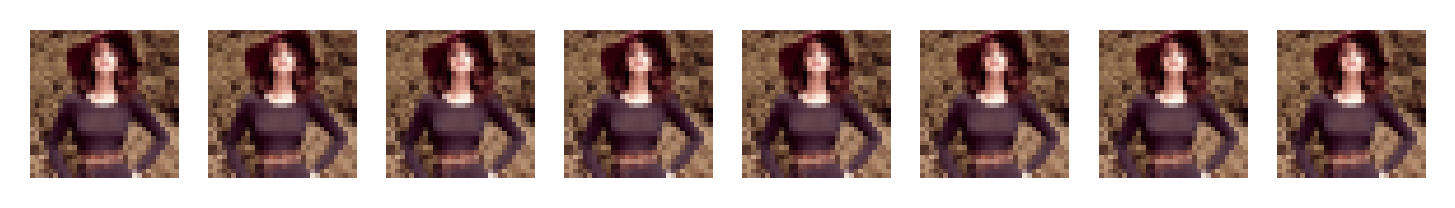

In [55]:
#visualize resized images
f, axes = plt.subplots(1,bs,dpi=300)

for img,ax in zip(x,axes):
    ax.axis('off')
    ax.imshow(img)

In [56]:
#use Image-GPT color palette and crop images
x_norm = normalize_img(x) #normalize pixels values to -1 to +1
samples = color_quantize_np(x_norm,clusters).reshape(x_norm.shape[:-1]) #map pixels to closest color cluster

n_px_crop = int(n_px/2)
primers = samples.reshape(-1,n_px,n_px)[:,:n_px_crop,:n_px] # crop top n_px_crop rows. These will be the conditioning tokens

context = samples.reshape(*samples.shape[:-2], -1)[:,:n_px_crop*n_px]

In [57]:
model.build(context.shape)
model.summary()

Model: "imagegpt_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     multiple                  65664     
                                                                 
 embedding_7 (Embedding)     multiple                  131072    
                                                                 
 decoder__layer_3 (Decoder_L  multiple                 396032    
 ayer)                                                           
                                                                 
Total params: 592,768
Trainable params: 592,768
Non-trainable params: 0
_________________________________________________________________


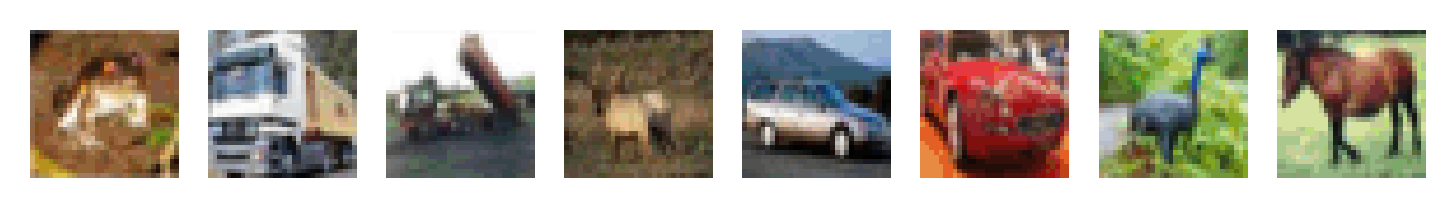

In [58]:
import cv2

(x_train,y_train),(x_test,y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train[:100]
x_train_norm = normalize_img(x_train)
x_train_samples = color_quantize_np(x_train_norm,clusters).reshape(x_train_norm.shape[:-1])
# print(x_train_samples.shape)

samples_img = (np.rint(127.5 * (clusters[x_train_samples[:8]]+1.0))).astype(np.uint8)
f, axes = plt.subplots(1,bs,dpi=300)
for img,ax in zip(samples_img,axes):
    ax.axis('off')
    ax.imshow(img)

x_train_samples = x_train_samples.reshape(*x_train_samples.shape[:-2], -1)
y_train = x_train_samples

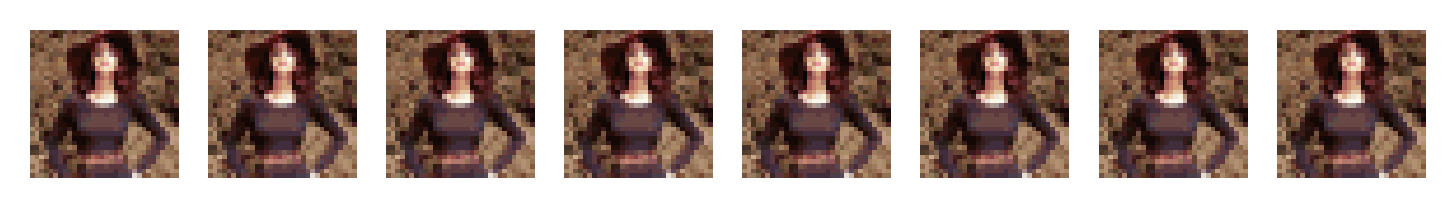

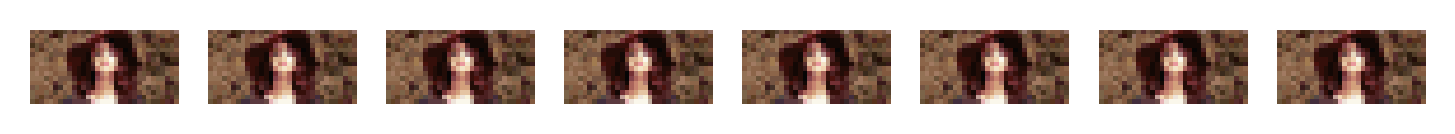

In [63]:
#visualize samples and crops with Image-GPT color palette. Should look similar to original resized images
samples_img = (np.rint(127.5 * (clusters[samples]+1.0))).astype(np.uint8)
primers_img = (np.rint(127.5 * (clusters[primers]+1.0))).astype(np.uint8) # convert color clusters back to pixels

f, axes = plt.subplots(1,bs,dpi=300)
for img,ax in zip(samples_img,axes):
    ax.axis('off')
    ax.imshow(img)

f, axes2 = plt.subplots(1,bs,dpi=300)
for img,ax in zip(primers_img,axes2):
    ax.axis('off')
    ax.imshow(img)

In [ ]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3) 
(x_train,y_train),(x_test,y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train[:10000]
y_train = y_train[:10000]
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(num_batch)

with tf.device('/device:GPU:0'):
      for epoch in range(num_epochs):
          print("\nStart of epoch %d" % (epoch,))
          for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
              with tf.GradientTape() as tape:
                    x_batch_train_norm = normalize_img(x_batch_train)
                    x_batch_train_samples = color_quantize_np(x_batch_train_norm,clusters).reshape(x_batch_train_norm.shape[:-1])
                    x_batch_train_samples = x_batch_train_samples.reshape(*x_batch_train_samples.shape[:-2], -1)
                    
                    h,emb_layer = model.call(x_batch_train_samples)
                    wte = emb_layer.get_weights()
                    h_flat = tf.reshape(h,[num_batch*maxlen,n_embd])
                    gen_logits = tf.matmul(h_flat,wte,transpose_b = True)
                    gen_logits = tf.reshape(gen_logits,[num_batch,maxlen,n_vocab])

                    gen_losses = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=gen_logits, labels=x_batch_train_samples)

                    grads = tape.gradient(gen_losses,model.trainable_weights)
                    optimizer.apply_gradients(zip(grads, model.trainable_weights))

                    # Log every 200 batches.
                    if step % 200 == 0:
                        print(
                            "Training loss (for one batch) at step %d: %.4f"
                            % (step, float(tf.reduce_mean(gen_losses)))
                        )
                        print("Seen so far: %s samples" % ((step + 1) * num_batch))
            
          model.save_weights("model_{}.h5".format(epoch))
            


Start of epoch 0
Training loss (for one batch) at step 0: 4.9919
Seen so far: 16 samples
